In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import copy
import folium
import pyeasyga.pyeasyga as pyeasyga
from pyeasyga.pyeasyga import GeneticAlgorithm
import itertools
from tqdm import tqdm
import time
from memory_profiler import memory_usage
import psutil
import os
from pyomo.environ import *
import re

In [18]:
#CARGA DE DATOS
#Se reutiliza el código de carga de datos del proyecto anterior

def load_distance_time_dic(path):
    data = pd.read_csv(path)
    distance = {}
    time = {}
    for i in range(len(data)):
        origen = int(data.iloc[i, 0])
        destino = int(data.iloc[i, 1])
        distance[origen, destino] = float(data.iloc[i, 2])
        time[origen, destino] = float(data.iloc[i, 3])
    return distance, time
5
def load_vehicles(path):
    data = pd.read_csv(path)
    vehicles = {}
    for i in range(len(data)):
        id = int(data.iloc[i, 0])
        capacity = int(data.iloc[i, 1])
        ran = float(data.iloc[i, 2])
        vehicles[id] = (capacity, ran)
    return vehicles

def load_demand(path):
    data = pd.read_csv(path)
    demand_dic = {}
    for i in range(len(data)):
        id = int(data.iloc[i, 1])
        demand = float(data.iloc[i, 2])
        demand_dic[id] = demand
    return demand_dic

def load_capacity(depositPath):
    data= pd.read_csv(depositPath)
    N = len(data)
    capacity_dic = {}
    for i in range(N):
        id = int(data.iloc[i, 1])
    
    return capacity_dic

def load_coordinates(depotsPath, clientsPath):
    coord = {}
    depot = pd.read_csv(depotsPath)
    client = pd.read_csv(clientsPath)
    for i in range(len(depot)):
        id = int(depot.iloc[i, 1])
        lat = float(depot.iloc[i, 3])
        long = float(depot.iloc[i, 2])
        coord[id] = [lat, long]
    for j in range(len(client)):
        id = int(client.iloc[j, 1])
        lat = float(client.iloc[j, 4])
        long = float(client.iloc[j, 3])
        coord[id] = [lat, long]
    return coord


In [19]:
distancia,time_dic = load_distance_time_dic('../Datos/caso3.csv')
vehiculos = load_vehicles('../Datos/vehicles.csv')
demanda = load_demand('..\Datos\clients.csv')
coord = load_coordinates('..\Datos\depots.csv', '..\Datos\clients.csv')
print(f"Distancia: {distancia}")
print(f"Vehiculos: {vehiculos}")
print(f"Demanda: {demanda}")
print(f"Coordenadas: {coord}")
print(f"Time: {time_dic}")



Distancia: {(1, 2): 33061.2, (1, 3): 10160.7, (1, 4): 6452.9, (1, 5): 21415.6, (1, 6): 16924.1, (1, 7): 20126.9, (1, 8): 11361.2, (1, 9): 4329.9, (1, 10): 31289.5, (1, 11): 13659.0, (1, 12): 26223.2, (1, 13): 16323.5, (1, 14): 10339.3, (1, 15): 20151.1, (1, 16): 9069.0, (1, 17): 13001.1, (1, 18): 11585.9, (1, 19): 5611.1, (1, 20): 35182.4, (1, 21): 5382.8, (1, 22): 15080.8, (1, 23): 15604.8, (1, 24): 17375.6, (1, 25): 18066.4, (1, 26): 15519.7, (1, 27): 22099.1, (1, 28): 21116.6, (1, 29): 18265.0, (1, 30): 24161.7, (1, 31): 22148.0, (1, 32): 11296.0, (1, 33): 7930.6, (1, 34): 25061.6, (1, 35): 23030.4, (1, 36): 18832.4, (1, 37): 30974.4, (1, 38): 15263.2, (1, 39): 26853.9, (1, 40): 19256.8, (1, 41): 7132.5, (1, 42): 18337.4, (1, 43): 14053.1, (1, 44): 14476.5, (1, 45): 22832.7, (1, 46): 22156.7, (1, 47): 20648.7, (1, 48): 28891.8, (1, 49): 23837.9, (1, 50): 14339.2, (1, 51): 18236.1, (1, 52): 11772.5, (1, 53): 11658.8, (1, 54): 23255.9, (1, 55): 17080.0, (1, 56): 11591.1, (1, 57): 2327

In [6]:
depot_id = 1  # depósito con demanda 0
pf = 15000
ft = 5000
cm = 700
gv = 0.411458

class VRPGeneticAlgorithm:
    def __init__(self, distance, demand, vehicles, coord):
        self.distance = distance
        self.demand = demand
        self.vehicles = vehicles
        self.coord = coord
        self.clientes = [c for c in demand.keys() if c != depot_id]
        self.demand[depot_id] = 0
        
    def create_individual(self, data):
        """Crear un individuo (conjunto de rutas)"""
        n_vehiculos = len(self.vehicles)
        rutas = [[] for _ in range(n_vehiculos)]
        clientes_copy = self.clientes[:]
        random.shuffle(clientes_copy)
        
        # Asignar cada cliente exactamente a un vehículo (round robin)
        for idx, cliente in enumerate(clientes_copy):
            v_id = idx % n_vehiculos
            rutas[v_id].append(cliente)
        
        # Agregar depósito al inicio y fin de cada ruta
        rutas = [[depot_id] + ruta + [depot_id] if ruta else [] for ruta in rutas]
        return rutas

    def mutate_individual(self, individual, data=None):
        """Mutación: mover un cliente de un vehículo a otro"""
        nuevas_rutas = copy.deepcopy(individual)
        
        # Encontrar vehículos con rutas no vacías
        vehiculos_con_rutas = [i for i, ruta in enumerate(nuevas_rutas) if len(ruta) > 2]
        
        if len(vehiculos_con_rutas) < 2:
            return nuevas_rutas
        
        # Elegir dos vehículos distintos
        v1, v2 = random.sample(vehiculos_con_rutas, 2)
        
        if len(nuevas_rutas[v1]) > 2:
            # Seleccionar cliente aleatorio (excluyendo depósitos)
            cliente = random.choice(nuevas_rutas[v1][1:-1])
            nuevas_rutas[v1].remove(cliente)
            
            # Insertar cliente en posición aleatoria en v2
            if len(nuevas_rutas[v2]) == 0:
                nuevas_rutas[v2] = [depot_id, cliente, depot_id]
            else:
                pos = random.randint(1, len(nuevas_rutas[v2]) - 1)
                nuevas_rutas[v2].insert(pos, cliente)
        
        return nuevas_rutas

    def crossover_individuals(self, parent1, parent2, data=None):
        """Cruzamiento: intercambiar segmentos de rutas entre padres"""
        hijo1 = copy.deepcopy(parent1)
        hijo2 = copy.deepcopy(parent2)
        
        # Seleccionar vehículo aleatorio para cruzar
        v = random.randint(0, len(parent1) - 1)
        
        if len(parent1[v]) > 2 and len(parent2[v]) > 2:
            # Extraer rutas sin depósitos
            ruta1 = parent1[v][1:-1]
            ruta2 = parent2[v][1:-1]
            
            if ruta1 and ruta2:
                # Punto de cruce
                split1 = random.randint(0, len(ruta1))
                split2 = random.randint(0, len(ruta2))
                
                # Crear nuevas rutas cruzadas
                nueva_ruta1 = ruta1[:split1] + ruta2[split2:]
                nueva_ruta2 = ruta2[:split2] + ruta1[split1:]
                
                # Reconstruir rutas con depósitos
                hijo1[v] = [depot_id] + nueva_ruta1 + [depot_id] if nueva_ruta1 else []
                hijo2[v] = [depot_id] + nueva_ruta2 + [depot_id] if nueva_ruta2 else []
                
                # Limpiar duplicados y reasignar clientes faltantes
                hijo1 = self._reparar_solucion(hijo1)
                hijo2 = self._reparar_solucion(hijo2)
        
        return hijo1, hijo2

    def _reparar_solucion(self, rutas):
        """Reparar solución eliminando duplicados y asignando clientes faltantes"""
        # Encontrar todos los clientes asignados
        asignados = set()
        for ruta in rutas:
            for cliente in ruta:
                if cliente != depot_id:
                    asignados.add(cliente)
        
        # Eliminar duplicados
        rutas_limpias = []
        clientes_vistos = set()
        
        for ruta in rutas:
            nueva_ruta = [depot_id]
            for cliente in ruta[1:-1]:  # Excluir depósitos
                if cliente not in clientes_vistos:
                    nueva_ruta.append(cliente)
                    clientes_vistos.add(cliente)
            if len(nueva_ruta) > 1:
                nueva_ruta.append(depot_id)
                rutas_limpias.append(nueva_ruta)
            else:
                rutas_limpias.append([])
        
        # Asignar clientes faltantes
        faltantes = set(self.clientes) - clientes_vistos
        for cliente in faltantes:
            v_id = random.randint(0, len(rutas_limpias) - 1)
            if len(rutas_limpias[v_id]) == 0:
                rutas_limpias[v_id] = [depot_id, cliente, depot_id]
            else:
                rutas_limpias[v_id].insert(-1, cliente)
        
        return rutas_limpias

    def fitness_individual(self, individual, data):
        """Evaluar fitness de un individuo (menor es mejor)"""
        claves_vehiculos = list(self.vehicles.keys())
        total_cost = 0
        
        for v_id, ruta in enumerate(individual):
            if len(ruta) <= 2:  # Ruta vacía
                continue
                
            cap_max, rango_max = self.vehicles[claves_vehiculos[v_id]]
            carga = 0
            distancia_total = 0
            
            # Calcular distancia y carga de la ruta
            for i in range(len(ruta) - 1):
                a, b = ruta[i], ruta[i + 1]
                distancia_total += self.distance.get((a, b), 9999999)
                if b != depot_id:
                    carga += self.demand.get(b, 0)
            
            # Calcular penalizaciones por violación de restricciones
            penalizacion = 0
            if carga > cap_max:
                penalizacion += 1e6 * (carga - cap_max)
            if distancia_total > rango_max:
                penalizacion += 1e6 * (distancia_total - rango_max)
            
            # Costo total del vehículo
            costo_vehiculo = gv * pf * distancia_total + ft + cm + penalizacion
            total_cost += costo_vehiculo
        
        # pyeasyga maximiza fitness, por lo que devolvemos el negativo del costo
        return -total_cost

    def tournament_selection(self, population, tournament_size=3):
        """Selección por torneo"""
        def tournament_select():
            # Seleccionar individuos aleatorios para el torneo
            tournament = random.sample(population, min(tournament_size, len(population)))
            # Devolver el mejor individuo del torneo
            return max(tournament, key=lambda x: x.fitness)
        
        return tournament_select

    def _verificar_asignacion_completa(self, rutas):
        """Verificar que todos los clientes estén asignados"""
        asignados = set()
        for ruta in rutas:
            for cliente in ruta:
                if cliente != depot_id:
                    asignados.add(cliente)
        
        faltantes = set(self.clientes) - asignados
        return faltantes


def run_ga_pyeasyga(distance, demand, vehicles, coord, 
                            n_generaciones=200, n_poblacion=50, 
                            prob_mutacion=0.2, prob_cruzamiento=0.8,
                            elitismo=5, tournament_size=3):
    """
    Versión mejorada del algoritmo genético con pyeasyga
    """
    # Crear instancia del problema VRP con verificaciones extendidas
    vrp = VRPGeneticAlgorithm(distance, demand, vehicles, coord)
    
    # Configurar algoritmo genético
    ga = GeneticAlgorithm(
        seed_data=None,
        population_size=n_poblacion,
        generations=n_generaciones,
        crossover_probability=prob_cruzamiento,
        mutation_probability=prob_mutacion,
        elitism=True,
        maximise_fitness=True
    )
    
    # Asignar funciones personalizadas
    ga.create_individual = vrp.create_individual
    ga.mutate_function = vrp.mutate_individual
    ga.crossover_function = vrp.crossover_individuals
    ga.fitness_function = vrp.fitness_individual
    
    fitness_history = []

    # Sobrescribir el método rank_population para guardar el mejor fitness
    original_rank_population = ga.rank_population
    def rank_and_record():
        original_rank_population()
        # El mejor fitness está en la primera posición después de ordenar
        fitness_history.append(ga.current_generation[0].fitness)
    ga.rank_population = rank_and_record
    
    # Ejecutar algoritmo genético
    print("Iniciando algoritmo genético mejorado...")
    ga.run()
    
    # Obtener mejor solución
    mejor_solucion = ga.best_individual()[1]
    mejor_fitness = -ga.best_individual()[0]
    
    # Verificaciones finales
    faltantes = vrp._verificar_asignacion_completa(mejor_solucion)
    if faltantes:
        print(f"¡Atención! Algunos nodos no fueron asignados: {faltantes}")
    else:
        print("Todos los nodos fueron asignados correctamente.")
    
    print(f"Mejor costo: {mejor_fitness}")
    
    # Obtener historial de fitness
    fitness_history = [-fitness for fitness in fitness_history]
    
    return mejor_solucion, fitness_history

In [7]:
import folium

def visualizar_rutas_folium(rutas, coord):
    # Crear mapa centrado en depósito o promedio de coordenadas
    lat_dep, lon_dep = coord[depot_id]
    m = folium.Map(location=[lat_dep, lon_dep], zoom_start=11, tiles='Cartodb Positron')

    colors = ['blue', 'green', 'cyan', 'magenta','olive', 'blue', 'orange', 'purple','red']
    icons = ['blue', 'green', 'lightblue', 'pink','lightgreen', 'blue', 'orange', 'darkpurple','red']

    for v, ruta in enumerate(rutas):
        if not ruta or len(ruta) < 2:
            continue

        # Construir lista de coordenadas para PolyLine: [(lat, lon), (lat, lon), ...]
        coords_ruta = [coord[n] for n in ruta]

        # Dibujar la ruta
        folium.PolyLine(
            coords_ruta,
            color=colors[v % len(colors)],
            weight=5,
            opacity=0.7,
            tooltip=f'Vehículo {v}'
        ).add_to(m)

        # Marcador inicio (depósito)
        folium.Marker(
            coords_ruta[0],
            popup="Inicio (Depósito)",
            icon=folium.Icon(color='black', icon='home')
        ).add_to(m)

        # Marcador fin de ruta
        folium.Marker(
            coords_ruta[-1],
            popup=f"Llegada Vehículo {v}",
            icon=folium.Icon(color=icons[v % len(icons)], icon='flag')
        ).add_to(m)

    return m


In [12]:
# Medir memoria antes
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss / 1024**2  # en MiB

# Ejecutar tu función normalmente
solucion, evol = run_ga_pyeasyga(distancia, demanda, vehiculos, coord, n_generaciones=300)

# Medir memoria después
mem_after = process.memory_info().rss / 1024**2  # en MiB

print(f"Memoria antes: {mem_before:.2f} MiB")
print(f"Memoria después: {mem_after:.2f} MiB")
print(f"Diferencia de memoria: {mem_after - mem_before:.2f} MiB")

mapa = visualizar_rutas_folium(solucion, coord)
mapa

Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1087351859991.4639
Memoria antes: 166.46 MiB
Memoria después: 166.84 MiB
Diferencia de memoria: 0.38 MiB


# Visualización y Estadísticas

In [13]:

def isClient(name):
    return bool(re.fullmatch(r'C\d+', name))

#SIN TERMINAR
def generateValidationFile(rutas, vehiculos, clientes):
    data = {
    'VehicleId':[] ,
    'DepotId':[] ,
    'InitialLoad':[] ,
    'RouteSequence':[] ,
    'ClientsServed':[] ,
    'DemandsSatisfied':[] , 
    'TotalDistance':[] , 
    'TotalTime':[] , 
    'FuelCost':[]
    }
    for ruta in rutas:
        print('r', ruta)
    for v in vehiculos:
        path = []
    
        print('v', v)
        data['VehicleId'].append("VEH" + "{:03d}".format(v))
        clients = 0
        demandas = []
        total_demand = 0
        for nodo in rutas[v-1]:
            if nodo == 1:
                path.append('CD1')
            else:
                path.append('C' + str(nodo))
                clients += 1
                demanda_c = demanda[nodo]
                print(demanda_c)
                demandas.append(str(demanda_c))
                total_demand += demanda_c
        print(demandas)
        data['RouteSequence'].append("-".join(path))
        data['ClientsServed'].append(clients)
        data['DepotId'].append('CD1')
        data['DemandsSatisfied'].append("-".join(demandas))
        data['InitialLoad'].append(total_demand)

        
        total_dist = 0
        t_time = 0
        ruta = rutas[v-1]
        for i in range(len(ruta) -1):
            total_dist += distancia[(ruta[i],ruta[i+1])]
            t_time += time_dic[(ruta[i],ruta[i+1])]
        t_time = t_time/60
        print(total_dist)
        print(t_time)



        data['TotalDistance'].append(round(total_dist,1))
        data['TotalTime'].append(round(t_time, 1))
        data['FuelCost'].append(round((total_dist)*pf))
        #print("time", t_time)

    print(data)
    df = pd.DataFrame(data)
    df.to_csv("verificacion_caso3_metaheuristica_1.csv", index=False)
    
generateValidationFile(solucion, vehiculos, demanda)   


r [1, 77, 87, 13, 44, 45, 5, 1]
r []
r [1, 85, 12, 76, 40, 42, 54, 19, 1]
r [1, 84, 49, 69, 51, 86, 79, 78, 17, 1]
r [1, 58, 11, 47, 1]
r []
r []
r [1, 23, 25, 27, 62, 52, 73, 1]
r [1, 8, 31, 20, 72, 28, 80, 35, 68, 21, 88, 10, 91, 83, 1]
r [1, 66, 82, 2, 37, 39, 60, 29, 41, 4, 1]
r []
r [1, 75, 26, 55, 16, 1]
r [1, 57, 7, 22, 24, 32, 59, 14, 53, 33, 1]
r []
r [1, 71, 64, 50, 38, 48, 34, 63, 3, 18, 1]
r []
r []
r [1, 15, 46, 81, 74, 9, 61, 1]
r []
r [1, 90, 36, 65, 30, 6, 67, 56, 1]
r []
r []
r []
r []
r []
r []
r []
r [1, 43, 89, 70, 1]
r []
r []
v 1
12.0
12.0
12.0
12.0
12.0
12.0
['12.0', '12.0', '12.0', '12.0', '12.0', '12.0']
88660.0
119.22666666666667
v 2
[]
0
0.0
v 3
12.0
12.0
12.0
12.0
12.0
12.0
12.0
['12.0', '12.0', '12.0', '12.0', '12.0', '12.0', '12.0']
103929.9
129.65
v 4
12.0
12.0
12.0
12.0
12.0
12.0
12.0
12.0
['12.0', '12.0', '12.0', '12.0', '12.0', '12.0', '12.0', '12.0']
92426.8
131.17999999999998
v 5
9.0
12.0
12.0
['9.0', '12.0', '12.0']
71765.2
97.13166666666666
v 6
[]


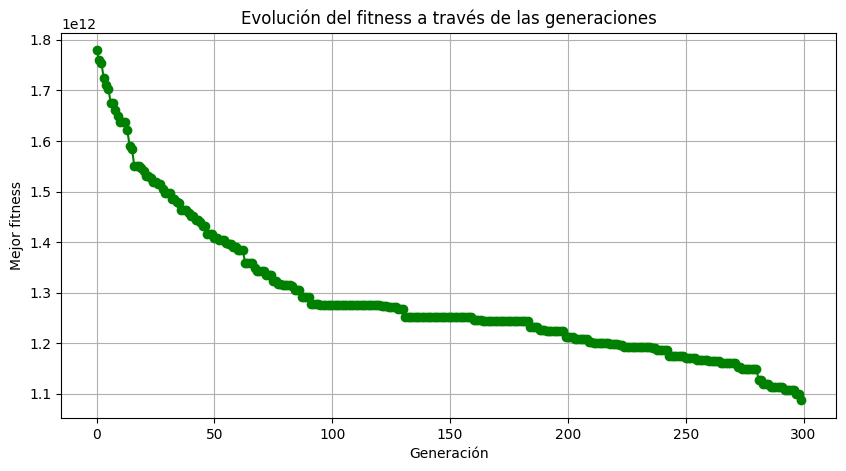

Costo total: 6691756891.464
Costo promedio por vehículo: 223058563.0488
Desviación estándar de costos: 287210990.9312737


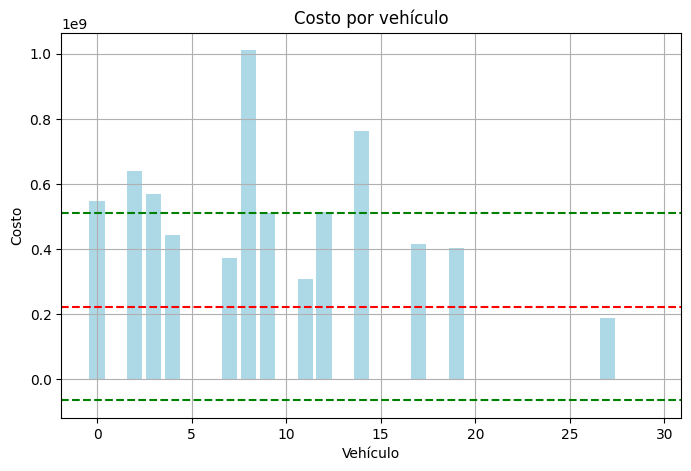

In [14]:

def graficar_costos_por_vehiculo(rutas, distancia, pf, ft, cm, gv):
    costos =[]
    for ruta in rutas:
        distance = 0
        for i in range(len(ruta)-1):
            distance += distancia[(ruta[i], ruta[i+1])]
        costo = gv*pf * distance + ft + cm
        costos.append(costo)
    media =  np.mean(costos)
    dev_est = np.std(costos) 
    print("Costo total:", sum(costos))
    print("Costo promedio por vehículo:", media)
    print("Desviación estándar de costos:", dev_est)

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(costos)), costos, color='lightblue')
    plt.axhline(y=media, color='r', linestyle='dashed')
    plt.axhline(y=media+dev_est, color='g', linestyle='dashed')
    plt.axhline(y=media-dev_est, color='g', linestyle='dashed')
    plt.xlabel('Vehículo')
    plt.ylabel('Costo')
    plt.title('Costo por vehículo')
    plt.grid(True)
    plt.show()


def graficar_evolucion_fitness(mejores_costos):
    plt.figure(figsize=(10, 5))
    plt.plot(mejores_costos, marker='o', color='green')
    plt.xlabel('Generación')
    plt.ylabel('Mejor fitness')
    plt.title('Evolución del fitness a través de las generaciones')
    plt.grid(True)
    plt.show()

graficar_evolucion_fitness(evol)
graficar_costos_por_vehiculo(solucion, distancia, pf, ft, cm, gv)


Como se ha hecho en los otros 2 casos, al evidenciar que es factible, se hace un estudio de parámetros

| #  | n_generaciones | n_poblacion | prob_mutacion | prob_cruzamiento | elitismo | tournament_size |
|----|----------------|-------------|----------------|-------------------|----------|------------------|
| 1  | 200            | 50          | 0.1            | 0.6               | True     | 3                |
| 2  | 200            | 50          | 0.1            | 0.6               | True     | 5                |
| 3  | 200            | 50          | 0.1            | 0.8               | True     | 3                |
| 4  | 200            | 50          | 0.1            | 0.8               | True     | 5                |
| 5  | 200            | 50          | 0.3            | 0.6               | True     | 3                |
| 6  | 200            | 50          | 0.3            | 0.6               | True     | 5                |
| 7  | 200            | 50          | 0.3            | 0.8               | True     | 3                |
| 8  | 200            | 50          | 0.3            | 0.8               | True     | 5                |
| 9  | 200            | 70          | 0.1            | 0.6               | True     | 3                |
| 10 | 200            | 70          | 0.1            | 0.6               | True     | 5                |
| 11 | 200            | 70          | 0.1            | 0.8               | True     | 3                |
| 12 | 200            | 70          | 0.1            | 0.8               | True     | 5                |
| 13 | 200            | 70          | 0.3            | 0.6               | True     | 3                |
| 14 | 200            | 70          | 0.3            | 0.6               | True     | 5                |
| 15 | 200            | 70          | 0.3            | 0.8               | True     | 3                |
| 16 | 200            | 70          | 0.3            | 0.8               | True     | 5                |
| 17 | 300            | 50          | 0.1            | 0.6               | True     | 3                |
| 18 | 300            | 50          | 0.1            | 0.6               | True     | 5                |
| 19 | 300            | 50          | 0.1            | 0.8               | True     | 3                |
| 20 | 300            | 50          | 0.1            | 0.8               | True     | 5                |
| 21 | 300            | 50          | 0.3            | 0.6               | True     | 3                |
| 22 | 300            | 50          | 0.3            | 0.6               | True     | 5                |
| 23 | 300            | 50          | 0.3            | 0.8               | True     | 3                |
| 24 | 300            | 50          | 0.3            | 0.8               | True     | 5                |
| 25 | 300            | 70          | 0.1            | 0.6               | True     | 3                |
| 26 | 300            | 70          | 0.1            | 0.6               | True     | 5                |
| 27 | 300            | 70          | 0.1            | 0.8               | True     | 3                |
| 28 | 300            | 70          | 0.1            | 0.8               | True     | 5                |
| 29 | 300            | 70          | 0.3            | 0.6               | True     | 3                |
| 30 | 300            | 70          | 0.3            | 0.6               | True     | 5                |
| 31 | 300            | 70          | 0.3            | 0.8               | True     | 3                |
| 32 | 300            | 70          | 0.3            | 0.8               | True     | 5                |
| 33 | 400            | 50          | 0.1            | 0.6               | True     | 3                |
| 34 | 400            | 50          | 0.1            | 0.6               | True     | 5                |
| 35 | 400            | 50          | 0.1            | 0.8               | True     | 3                |
| 36 | 400            | 50          | 0.1            | 0.8               | True     | 5                |
| 37 | 400            | 50          | 0.3            | 0.6               | True     | 3                |
| 38 | 400            | 50          | 0.3            | 0.6               | True     | 5                |
| 39 | 400            | 50          | 0.3            | 0.8               | True     | 3                |
| 40 | 400            | 50          | 0.3            | 0.8               | True     | 5                |
| 41 | 400            | 70          | 0.1            | 0.6               | True     | 3                |
| 42 | 400            | 70          | 0.1            | 0.6               | True     | 5                |
| 43 | 400            | 70          | 0.1            | 0.8               | True     | 3                |
| 44 | 400            | 70          | 0.1            | 0.8               | True     | 5                |
| 45 | 400            | 70          | 0.3            | 0.6               | True     | 3                |
| 46 | 400            | 70          | 0.3            | 0.6               | True     | 5                |
| 47 | 400            | 70          | 0.3            | 0.8               | True     | 3                |
| 48 | 400            | 70          | 0.3            | 0.8               | True     | 5                |


In [ ]:
def experimento_ga(distance, demand, vehicles, coord, 
                   param_grid, repeticiones=3):
    
    resultados = []

    # Crear todas las combinaciones posibles de parámetros
    keys, values = zip(*param_grid.items())
    combinaciones = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    for config in tqdm(combinaciones, desc="Configuraciones"):
        costos = []
        tiempos = []

        for r in range(repeticiones):
            seed = 42 + r  # Semilla diferente por repetición
            random.seed(seed)

            start_time = time.process_time()
            solucion, historial = run_ga_pyeasyga(
                distance=distance,
                demand=demand,
                vehicles=vehicles,
                coord=coord,
                n_generaciones=config['n_generaciones'],
                n_poblacion=config['n_poblacion'],
                prob_mutacion=config['prob_mutacion'],
                prob_cruzamiento=config['prob_cruzamiento'],
                elitismo=config['elitismo'],
                tournament_size=config['tournament_size']
            )
            end_time = time.process_time()
            tiempo_cpu = end_time - start_time
            
            # Valor de la función objetivo (último valor en historial)
            costo_final = historial[-1]
            costos.append(costo_final)
            tiempos.append(tiempo_cpu)
        
        resultados.append({
            **config,
            "mejor": np.min(costos),
            "peor": np.max(costos),
            "promedio": np.mean(costos),
            "std": np.std(costos),
            "tiempo_prom": np.mean(tiempos)
        })
    
    df_resultados = pd.DataFrame(resultados)
    return df_resultados


In [90]:
param_grid = {
    "n_generaciones": [200,300,400],
    "n_poblacion": [50,70],
    "prob_mutacion": [0.1,0.3],
    "prob_cruzamiento": [0.6,0.8],
    "elitismo": [True],
    "tournament_size": [3,5]
}

# Ejecutar el experimento
df_resultados = experimento_ga(distancia, demanda, vehiculos, coord, param_grid, repeticiones=3)

# Mostrar resultados ordenados por mejor promedio
df_resultados.sort_values("promedio").head()

Configuraciones:   0%|          | 0/48 [00:00<?, ?it/s]

Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1258863117870.5383
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1213051909467.5562
Iniciando algoritmo genético mejorado...


Configuraciones:   2%|▏         | 1/48 [00:06<05:09,  6.59s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1159050892838.787
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1258863117870.5383
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1213051909467.5562
Iniciando algoritmo genético mejorado...


Configuraciones:   4%|▍         | 2/48 [00:13<05:19,  6.95s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1159050892838.787
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1121508365868.849
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1213756829688.353
Iniciando algoritmo genético mejorado...


Configuraciones:   6%|▋         | 3/48 [00:20<05:17,  7.06s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1216960880559.669
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1121508365868.849
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1213756829688.353
Iniciando algoritmo genético mejorado...


Configuraciones:   8%|▊         | 4/48 [00:27<05:06,  6.97s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1216960880559.669
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1197203670045.768
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1115514061119.723
Iniciando algoritmo genético mejorado...


Configuraciones:  10%|█         | 5/48 [00:34<04:57,  6.91s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1247176550575.535
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1197203670045.768
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1115514061119.723
Iniciando algoritmo genético mejorado...


Configuraciones:  12%|█▎        | 6/48 [00:41<04:50,  6.92s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1247176550575.535
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1164302651786.8308
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1145733044188.3901
Iniciando algoritmo genético mejorado...


Configuraciones:  15%|█▍        | 7/48 [00:49<04:50,  7.10s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1170598944091.948
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1164302651786.8308
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1145733044188.3901
Iniciando algoritmo genético mejorado...


Configuraciones:  17%|█▋        | 8/48 [00:56<04:49,  7.24s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1170598944091.948
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1145105732116.995
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1054824965679.7549
Iniciando algoritmo genético mejorado...


Configuraciones:  19%|█▉        | 9/48 [01:06<05:17,  8.13s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1155479039464.2588
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1145105732116.995
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1054824965679.7549
Iniciando algoritmo genético mejorado...


Configuraciones:  21%|██        | 10/48 [01:16<05:24,  8.53s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1155479039464.2588
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1149315598188.721
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1168546397920.645
Iniciando algoritmo genético mejorado...


Configuraciones:  23%|██▎       | 11/48 [01:25<05:27,  8.85s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1177910086761.136
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1149315598188.721
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1168546397920.645
Iniciando algoritmo genético mejorado...


Configuraciones:  25%|██▌       | 12/48 [01:36<05:37,  9.38s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1177910086761.136
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1196872615737.9653
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1180312335466.9167
Iniciando algoritmo genético mejorado...


Configuraciones:  27%|██▋       | 13/48 [01:46<05:40,  9.74s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1219871660005.552
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1196872615737.9653
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1180312335466.9167
Iniciando algoritmo genético mejorado...


Configuraciones:  29%|██▉       | 14/48 [01:57<05:38,  9.95s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1219871660005.552
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1125671242355.135
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1069886053047.8009
Iniciando algoritmo genético mejorado...


Configuraciones:  31%|███▏      | 15/48 [02:08<05:38, 10.27s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1148176544782.5598
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1125671242355.135
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1069886053047.8009
Iniciando algoritmo genético mejorado...


Configuraciones:  33%|███▎      | 16/48 [02:19<05:35, 10.49s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1148176544782.5598
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1199535883095.2212
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1194618886980.3132
Iniciando algoritmo genético mejorado...


Configuraciones:  35%|███▌      | 17/48 [02:29<05:18, 10.26s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1122726753753.609
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1199535883095.2212
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1194618886980.3132
Iniciando algoritmo genético mejorado...


Configuraciones:  38%|███▊      | 18/48 [02:39<05:07, 10.25s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1122726753753.609
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1067810526000.135
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1166043319511.504
Iniciando algoritmo genético mejorado...


Configuraciones:  40%|███▉      | 19/48 [02:50<05:03, 10.46s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1192754092183.9749
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1067810526000.135
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1166043319511.504
Iniciando algoritmo genético mejorado...


Configuraciones:  42%|████▏     | 20/48 [03:01<04:58, 10.65s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1192754092183.9749
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1159580589631.1672
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1070687697084.835
Iniciando algoritmo genético mejorado...


Configuraciones:  44%|████▍     | 21/48 [03:12<04:49, 10.72s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1191167258841.918
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1159580589631.1672
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1070687697084.835
Iniciando algoritmo genético mejorado...


Configuraciones:  46%|████▌     | 22/48 [03:23<04:46, 11.03s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1191167258841.918
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1150602367432.9128
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1105175903014.902
Iniciando algoritmo genético mejorado...


Configuraciones:  48%|████▊     | 23/48 [03:35<04:39, 11.20s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1141846153313.134
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1150602367432.9128
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1105175903014.902
Iniciando algoritmo genético mejorado...


Configuraciones:  50%|█████     | 24/48 [03:47<04:34, 11.44s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1141846153313.134
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1092266139832.7568
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1034159020790.3281
Iniciando algoritmo genético mejorado...


Configuraciones:  52%|█████▏    | 25/48 [04:02<04:48, 12.55s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1136894769728.545
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1092266139832.7568
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1034159020790.3281
Iniciando algoritmo genético mejorado...


Configuraciones:  54%|█████▍    | 26/48 [04:16<04:47, 13.06s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1136894769728.545
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1099652760153.748
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1122629028441.016
Iniciando algoritmo genético mejorado...


Configuraciones:  56%|█████▋    | 27/48 [04:32<04:50, 13.84s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1140581289270.167
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1099652760153.748
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1122629028441.016
Iniciando algoritmo genético mejorado...


Configuraciones:  58%|█████▊    | 28/48 [04:48<04:46, 14.35s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1140581289270.167
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1194570393882.218
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1115720664741.4092
Iniciando algoritmo genético mejorado...


Configuraciones:  60%|██████    | 29/48 [05:04<04:41, 14.84s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1168345778824.28
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1194570393882.218
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1115720664741.4092
Iniciando algoritmo genético mejorado...


Configuraciones:  62%|██████▎   | 30/48 [05:19<04:30, 15.01s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1168345778824.28
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1097560803373.601
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1035400645547.3549
Iniciando algoritmo genético mejorado...


Configuraciones:  65%|██████▍   | 31/48 [05:36<04:24, 15.53s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1107472948187.8901
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1097560803373.601
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1035400645547.3549
Iniciando algoritmo genético mejorado...


Configuraciones:  67%|██████▋   | 32/48 [05:52<04:12, 15.81s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1107472948187.8901
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1194247242512.127
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1165269366524.752
Iniciando algoritmo genético mejorado...


Configuraciones:  69%|██████▉   | 33/48 [06:05<03:45, 15.02s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1105181986731.539
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1194247242512.127
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1165269366524.752
Iniciando algoritmo genético mejorado...


Configuraciones:  71%|███████   | 34/48 [06:18<03:21, 14.40s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1105181986731.539
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1048080140570.181
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1119555015602.141
Iniciando algoritmo genético mejorado...


Configuraciones:  73%|███████▎  | 35/48 [06:32<03:05, 14.27s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1167925292033.92
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1048080140570.181
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1119555015602.141
Iniciando algoritmo genético mejorado...


Configuraciones:  75%|███████▌  | 36/48 [06:46<02:50, 14.23s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1167925292033.92
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1108344479108.3171
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1060260507769.568
Iniciando algoritmo genético mejorado...


Configuraciones:  77%|███████▋  | 37/48 [07:01<02:36, 14.23s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1149834751148.935
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1108344479108.3171
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1060260507769.568
Iniciando algoritmo genético mejorado...


Configuraciones:  79%|███████▉  | 38/48 [07:15<02:21, 14.16s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1149834751148.935
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1127539797648.9219
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1078087056258.796
Iniciando algoritmo genético mejorado...


Configuraciones:  81%|████████▏ | 39/48 [07:31<02:13, 14.86s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1044904091130.5479
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1127539797648.9219
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1078087056258.796
Iniciando algoritmo genético mejorado...


Configuraciones:  83%|████████▎ | 40/48 [07:48<02:02, 15.33s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1044904091130.5479
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1064062115191.841
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1021078144054.612
Iniciando algoritmo genético mejorado...


Configuraciones:  85%|████████▌ | 41/48 [08:08<01:58, 16.90s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1096048464666.0231
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1064062115191.841
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1021078144054.612
Iniciando algoritmo genético mejorado...


Configuraciones:  88%|████████▊ | 42/48 [08:28<01:46, 17.80s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1096048464666.0231
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1092953821569.969
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1087140455242.44
Iniciando algoritmo genético mejorado...


Configuraciones:  90%|████████▉ | 43/48 [08:49<01:34, 18.85s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1134707485682.228
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1092953821569.969
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1087140455242.44
Iniciando algoritmo genético mejorado...


Configuraciones:  92%|█████████▏| 44/48 [09:11<01:18, 19.64s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1134707485682.228
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1161216336508.873
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1094155175547.2561
Iniciando algoritmo genético mejorado...


Configuraciones:  94%|█████████▍| 45/48 [09:33<01:00, 20.28s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1135849637168.661
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1161216336508.873
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1094155175547.2561
Iniciando algoritmo genético mejorado...


Configuraciones:  96%|█████████▌| 46/48 [09:52<00:40, 20.13s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1135849637168.661
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1049679725286.513
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1015048677425.3959
Iniciando algoritmo genético mejorado...


Configuraciones:  98%|█████████▊| 47/48 [10:14<00:20, 20.60s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1056764126072.7509
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1049679725286.513
Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 1015048677425.3959
Iniciando algoritmo genético mejorado...


Configuraciones: 100%|██████████| 48/48 [10:36<00:00, 13.27s/it]

Todos los nodos fueron asignados correctamente.
Mejor costo: 1056764126072.7509


,n_generaciones,n_poblacion,prob_mutacion,prob_cruzamiento,elitismo,tournament_size,mejor,peor,promedio,std,tiempo_prom
46,400,70,0.3,0.8,True,3,1.015049e+12,1.056764e+12,1.040498e+12,1.822598e+10,6.937500
47,400,70,0.3,0.8,True,5,1.015049e+12,1.056764e+12,1.040498e+12,1.822598e+10,7.062500
40,400,70,0.1,0.6,True,3,1.021078e+12,1.096048e+12,1.060396e+12,3.071608e+10,6.489583
41,400,70,0.1,0.6,True,5,1.021078e+12,1.096048e+12,1.060396e+12,3.071608e+10,6.333333
30,300,70,0.3,0.8,True,3,1.035401e+12,1.107473e+12,1.080145e+12,3.189663e+10,5.348958


Las gráficas fueron realizadas con ayuda de la IA generativa Claude en su modelo Sonnet 4 bajo el prompt: quiero una gráfica que me permita ver 
registrar el tiempo de CPU y compararlo con la  valor de la función objetivo, 
mejor, peor, media, desviación estándar

In [91]:
def grafico_tiempo_cpu_parametros(df_resultados):
    """
    Crea una gráfica que muestra la relación entre tiempo de CPU y parámetros del GA
    """
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Análisis de Tiempo de CPU vs Parámetros del Algoritmo Genético', 
                 fontsize=16, fontweight='bold', y=0.95)
    
    # Colores consistentes para cada configuración
    colors = plt.cm.Set3(np.linspace(0, 1, len(df_resultados)))
    
    # 1. Tiempo CPU vs Número de Generaciones
    ax1.scatter(df_resultados['n_generaciones'], df_resultados['tiempo_prom'], 
               s=100, c=colors, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Línea de tendencia
    z = np.polyfit(df_resultados['n_generaciones'], df_resultados['tiempo_prom'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(df_resultados['n_generaciones'].min(), 
                         df_resultados['n_generaciones'].max(), 100)
    ax1.plot(x_trend, p(x_trend), "--", color='red', alpha=0.8, linewidth=2)
    
    ax1.set_xlabel('Número de Generaciones', fontsize=12)
    ax1.set_ylabel('Tiempo CPU Promedio (s)', fontsize=12)
    ax1.set_title('Tiempo vs Generaciones', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Correlación
    corr_gen = df_resultados['n_generaciones'].corr(df_resultados['tiempo_prom'])
    ax1.text(0.05, 0.95, f'Correlación: {corr_gen:.3f}', 
             transform=ax1.transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # 2. Tiempo CPU vs Tamaño de Población
    ax2.scatter(df_resultados['n_poblacion'], df_resultados['tiempo_prom'], 
               s=100, c=colors, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Línea de tendencia
    z = np.polyfit(df_resultados['n_poblacion'], df_resultados['tiempo_prom'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(df_resultados['n_poblacion'].min(), 
                         df_resultados['n_poblacion'].max(), 100)
    ax2.plot(x_trend, p(x_trend), "--", color='red', alpha=0.8, linewidth=2)
    
    ax2.set_xlabel('Tamaño de Población', fontsize=12)
    ax2.set_ylabel('Tiempo CPU Promedio (s)', fontsize=12)
    ax2.set_title('Tiempo vs Tamaño Población', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Correlación
    corr_pob = df_resultados['n_poblacion'].corr(df_resultados['tiempo_prom'])
    ax2.text(0.05, 0.95, f'Correlación: {corr_pob:.3f}', 
             transform=ax2.transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # 3. Heatmap de Tiempo por combinación de parámetros principales
    # Crear tabla pivot para el heatmap
    pivot_data = df_resultados.pivot_table(
        values='tiempo_prom', 
        index='n_generaciones', 
        columns='n_poblacion', 
        aggfunc='mean'
    )
    
    im = ax3.imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
    ax3.set_xticks(range(len(pivot_data.columns)))
    ax3.set_yticks(range(len(pivot_data.index)))
    ax3.set_xticklabels(pivot_data.columns)
    ax3.set_yticklabels(pivot_data.index)
    ax3.set_xlabel('Tamaño de Población', fontsize=12)
    ax3.set_ylabel('Número de Generaciones', fontsize=12)
    ax3.set_title('Mapa de Calor: Tiempo CPU', fontsize=14, fontweight='bold')
    
    # Añadir valores en el heatmap
    for i in range(len(pivot_data.index)):
        for j in range(len(pivot_data.columns)):
            if not pd.isna(pivot_data.iloc[i, j]):
                text = ax3.text(j, i, f'{pivot_data.iloc[i, j]:.2f}', 
                               ha="center", va="center", color="black", fontweight='bold')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax3, shrink=0.8)
    cbar.set_label('Tiempo CPU (s)', rotation=270, labelpad=15)
    
    # 4. Gráfico de barras: Tiempo promedio por configuración ordenado
    df_sorted = df_resultados.sort_values('tiempo_prom')
    config_labels = [f"C{i+1}" for i in range(len(df_sorted))]
    
    bars = ax4.bar(range(len(df_sorted)), df_sorted['tiempo_prom'], 
                   color=plt.cm.viridis(np.linspace(0, 1, len(df_sorted))), 
                   alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax4.set_xlabel('Configuraciones (ordenadas por tiempo)', fontsize=12)
    ax4.set_ylabel('Tiempo CPU Promedio (s)', fontsize=12)
    ax4.set_title('Tiempo CPU por Configuración', fontsize=14, fontweight='bold')
    ax4.set_xticks(range(len(df_sorted)))
    ax4.set_xticklabels(config_labels, rotation=45)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Añadir valores encima de las barras
    for i, (bar, tiempo) in enumerate(zip(bars, df_sorted['tiempo_prom'])):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{tiempo:.2f}s', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Añadir información de parámetros para las configuraciones más lentas y rápidas
    mas_rapida = df_sorted.iloc[0]
    mas_lenta = df_sorted.iloc[-1]
    
    info_text = f"""
    Configuración más rápida: {mas_rapida['tiempo_prom']:.2f}s
    Gen: {mas_rapida['n_generaciones']}, Pob: {mas_rapida['n_poblacion']}
    
    Configuración más lenta: {mas_lenta['tiempo_prom']:.2f}s  
    Gen: {mas_lenta['n_generaciones']}, Pob: {mas_lenta['n_poblacion']}
    
    Factor de diferencia: {mas_lenta['tiempo_prom']/mas_rapida['tiempo_prom']:.1f}x
    """
    
    ax4.text(0.02, 0.98, info_text, transform=ax4.transAxes, 
             bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8),
             verticalalignment='top', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir análisis detallado
    print("="*70)
    print("ANÁLISIS DE TIEMPO DE CPU vs PARÁMETROS")
    print("="*70)
    
    print(f"\nTiempo CPU mínimo: {df_resultados['tiempo_prom'].min():.3f}s")
    print(f"Tiempo CPU máximo: {df_resultados['tiempo_prom'].max():.3f}s")
    print(f"Tiempo CPU promedio: {df_resultados['tiempo_prom'].mean():.3f}s")
    print(f"Diferencia máxima: {df_resultados['tiempo_prom'].max()/df_resultados['tiempo_prom'].min():.1f}x")
    
    print(f"\nCorrelación Generaciones-Tiempo: {corr_gen:.3f}")
    print(f"Correlación Población-Tiempo: {corr_pob:.3f}")
    
    # Análisis del impacto de cada parámetro
    print("\nIMPACTO DE PARÁMETROS EN TIEMPO CPU:")
    print("-" * 40)
    
    # Agrupar por cada parámetro y ver el efecto en tiempo
    for param in ['n_generaciones', 'n_poblacion', 'prob_mutacion', 'prob_cruzamiento', 'tournament_size']:
        if param in df_resultados.columns:
            grouped = df_resultados.groupby(param)['tiempo_prom'].agg(['mean', 'std']).round(3)
            print(f"\n{param.replace('_', ' ').title()}:")
            for value, stats in grouped.iterrows():
                print(f"  {value}: {stats['mean']:.3f}s (±{stats['std']:.3f})")
    
    return fig

# Función auxiliar para crear una tabla resumen
def tabla_resumen_tiempo_parametros(df_resultados):
    """
    Crea una tabla resumen del análisis tiempo-parámetros
    """
    print("\n" + "="*80)
    print("TABLA RESUMEN: CONFIGURACIONES ORDENADAS POR TIEMPO CPU")
    print("="*80)
    
    df_sorted = df_resultados.sort_values('tiempo_prom')
    
    print(f"{'Config':<8} {'Gen':<6} {'Pob':<6} {'Mut':<6} {'Cruz':<6} {'Tour':<6} {'Tiempo':<10} {'F.O.Prom':<12}")
    print("-" * 80)
    
    for i, (idx, row) in enumerate(df_sorted.iterrows()):
        print(f"C{i+1:<7} {row['n_generaciones']:<6} {row['n_poblacion']:<6} "
              f"{row['prob_mutacion']:<6.1f} {row['prob_cruzamiento']:<6.1f} "
              f"{row['tournament_size']:<6} {row['tiempo_prom']:<10.3f} {row['promedio']:<12.2f}")

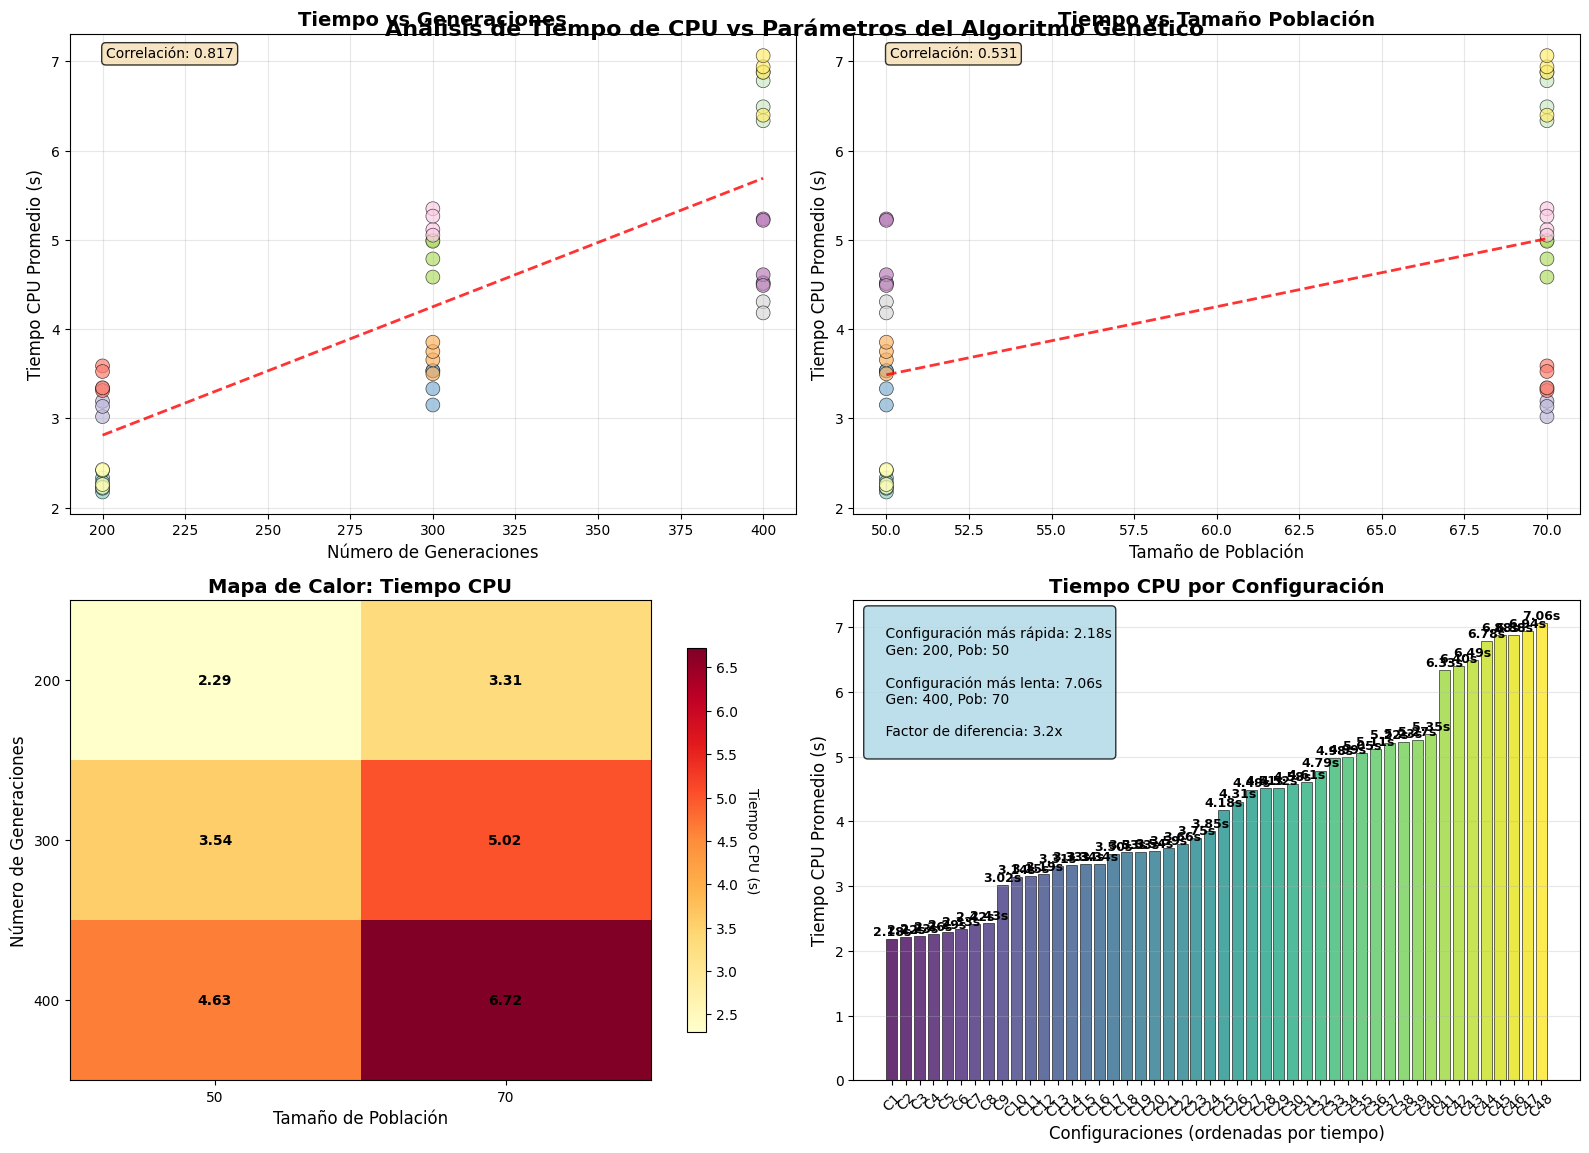

ANÁLISIS DE TIEMPO DE CPU vs PARÁMETROS

Tiempo CPU mínimo: 2.177s
Tiempo CPU máximo: 7.062s
Tiempo CPU promedio: 4.252s
Diferencia máxima: 3.2x

Correlación Generaciones-Tiempo: 0.817
Correlación Población-Tiempo: 0.531

IMPACTO DE PARÁMETROS EN TIEMPO CPU:
----------------------------------------

N Generaciones:
  200: 2.800s (±0.543)
  300: 4.278s (±0.796)
  400: 5.677s (±1.125)

N Poblacion:
  50: 3.489s (±1.009)
  70: 5.014s (±1.441)

Prob Mutacion:
  0.1: 4.109s (±1.438)
  0.3: 4.395s (±1.483)

Prob Cruzamiento:
  0.6: 4.114s (±1.410)
  0.8: 4.390s (±1.511)

Tournament Size:
  3: 4.261s (±1.494)
  5: 4.242s (±1.441)

TABLA RESUMEN: CONFIGURACIONES ORDENADAS POR TIEMPO CPU
Config   Gen    Pob    Mut    Cruz   Tour   Tiempo     F.O.Prom    
--------------------------------------------------------------------------------
C1       200    50     0.1    0.6    3      2.177      1210321973392.29
C2       200    50     0.1    0.8    5      2.219      1184075358705.62
C3       200    50 

In [92]:
grafico_tiempo_cpu_parametros(df_resultados)
tabla_resumen_tiempo_parametros(df_resultados)

## Analisis de Escalabilidad

## Comparación son soluciones previas (Pyomo)